In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim
import random
import torchvision.datasets as dsets
import torchvision.transforms as transforms #should be used to convert images to pytorch tensors

In [ ]:
device = 'cuda' if torch.cuda.is_available else 'cpu'

In [ ]:
x_train = pd.read_pickle("/content/drive/MyDrive/CSCE464/Datasets/CICIDS/CICIDS_train_2labels.pkl")
y_train = pd.read_pickle("/content/drive/MyDrive/CSCE464/Datasets/CICIDS/CICIDS_train_2labels_y.pkl")

x_val = pd.read_pickle("/content/drive/MyDrive/CSCE464/Datasets/CICIDS/CICIDS_val_2labels.pkl")
y_val = pd.read_pickle("/content/drive/MyDrive/CSCE464/Datasets/CICIDS/CICIDS_val_2labels_y.pkl")

x_test = pd.read_pickle("/content/drive/MyDrive/CSCE464/Datasets/CICIDS/CICIDS_test_2labels.pkl")
y_test = pd.read_pickle("/content/drive/MyDrive/CSCE464/Datasets/CICIDS/CICIDS_test_2labels_y.pkl")

In [ ]:
x_train.shape

(130028, 80)

In [ ]:
y_train.shape

(130028,)

In [ ]:
x_val.shape

(14448, 80)

In [ ]:
y_val.shape

(14448,)

In [ ]:
x_test.shape

(36119, 80)

In [ ]:
y_test.shape

(36119,)

In [ ]:
x_train

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,is_Normal,is_Attack
0,80,61270,3,5,26,11601,20,0,8.666667,10.263203,...,0.0,0.0,0,0,0.0,0.0,0,0,0,1
1,80,6651838,5,0,30,0,6,6,6.000000,0.000000,...,2009.0,0.0,2009,2009,6649829.0,0.0,6649829,6649829,0,1
2,80,78507407,8,6,56,11601,20,0,7.000000,5.656854,...,57988.0,0.0,57988,57988,78400000.0,0.0,78400000,78400000,0,1
3,80,1048295,3,5,26,11607,20,0,8.666667,10.263203,...,0.0,0.0,0,0,0.0,0.0,0,0,0,1
4,53,24633,1,1,47,208,47,47,47.000000,0.000000,...,0.0,0.0,0,0,0.0,0.0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130023,80,1213953,3,6,26,11607,20,0,8.666667,10.263203,...,0.0,0.0,0,0,0.0,0.0,0,0,0,1
130024,9429,3,2,0,37,0,31,6,18.500000,17.677670,...,0.0,0.0,0,0,0.0,0.0,0,0,1,0
130025,56063,1,2,0,12,0,6,6,6.000000,0.000000,...,0.0,0.0,0,0,0.0,0.0,0,0,1,0
130026,54572,91684,7,2,11607,26,5840,0,1658.142857,2430.302891,...,0.0,0.0,0,0,0.0,0.0,0,0,1,0


In [ ]:
x_train = x_train.drop(['is_Normal', 'is_Attack'], axis=1)
x_val = x_val.drop(['is_Normal', 'is_Attack'], axis=1)
x_test = x_test.drop(['is_Normal', 'is_Attack'], axis=1)

In [ ]:
x_train.shape

(130028, 78)

In [ ]:
x_val.shape

(14448, 78)

In [ ]:
x_test.shape

(36119, 78)

In [ ]:
x_train.replace([np.inf, -np.inf], np.nan, inplace=True)
x_val.replace([np.inf, -np.inf], np.nan, inplace=True)
x_test.replace([np.inf, -np.inf], np.nan, inplace=True)

In [ ]:
x_train.fillna(999, inplace=True)
x_val.fillna(999, inplace=True)
x_test.fillna(999, inplace=True)

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)

In [ ]:
from torch.utils.data import Dataset, DataLoader, TensorDataset
class Data(Dataset):
  def __init__(self, x, y):
    self.x = torch.FloatTensor(x)
    self.y = torch.LongTensor(y)
    self.len = self.y.shape[0]

  def __getitem__(self, index):
    return self.x[index], self.y[index]

  def __len__(self):
    return self.len

In [ ]:
train = Data(x_train, y_train)
val = Data(x_val, y_val)
test = Data(x_test, y_test)

In [ ]:
train_loader = DataLoader(train, batch_size=1000, shuffle=True)
val_loader = DataLoader(val, batch_size=len(val), shuffle=True)
test_loader = DataLoader(test, batch_size=len(test), shuffle=True)

In [ ]:
linear1 = torch.nn.Linear(78, 512, bias=False)
linear2 = torch.nn.Linear(512, 256, bias=False)
linear3 = torch.nn.Linear(256, 128, bias=False)
linear4 = torch.nn.Linear(128, 2, bias=True)
relu = torch.nn.ReLU()

In [ ]:
class MLP(nn.Module):
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
        linear1,
        relu,
        # nn.Dropout(0.5),
        linear2,
        relu,
        # nn.Dropout(0.5),
        linear3,
        relu,
        # nn.Dropout(0.5),
        linear4,
        nn.Softmax())
  def forward(self, x):
    return self.layers(x)

In [ ]:
model = MLP().to(device)
print(model)

MLP(
  (layers): Sequential(
    (0): Linear(in_features=78, out_features=512, bias=False)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=False)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=False)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=2, bias=True)
    (7): Softmax(dim=None)
  )
)


In [ ]:
loss = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch  1 / 20 Cost: 0.31326 Training ACC: 100.00%
Epoch  2 / 20 Cost: 0.31327 Training ACC: 100.00%
Epoch  3 / 20 Cost: 0.31326 Training ACC: 100.00%
Epoch  4 / 20 Cost: 0.31326 Training ACC: 100.00%
Epoch  5 / 20 Cost: 0.31326 Training ACC: 100.00%
Epoch  6 / 20 Cost: 0.31326 Training ACC: 100.00%
Epoch  7 / 20 Cost: 0.31326 Training ACC: 100.00%
Epoch  8 / 20 Cost: 0.31327 Training ACC: 100.00%
Epoch  9 / 20 Cost: 0.31326 Training ACC: 100.00%
Epoch 10 / 20 Cost: 0.31326 Training ACC: 100.00%
Epoch 11 / 20 Cost: 0.31326 Training ACC: 100.00%
Epoch 12 / 20 Cost: 0.31326 Training ACC: 100.00%
Epoch 13 / 20 Cost: 0.31326 Training ACC: 100.00%
Epoch 14 / 20 Cost: 0.31326 Training ACC: 100.00%
Epoch 15 / 20 Cost: 0.31326 Training ACC: 100.00%
Epoch 16 / 20 Cost: 0.31326 Training ACC: 100.00%
Epoch 17 / 20 Cost: 0.31326 Training ACC: 100.00%
Epoch 18 / 20 Cost: 0.31326 Training ACC: 100.00%
Epoch 19 / 20 Cost: 0.31326 Training ACC: 100.00%
Epoch 20 / 20 Cost: 0.31326 Training ACC: 100.00%


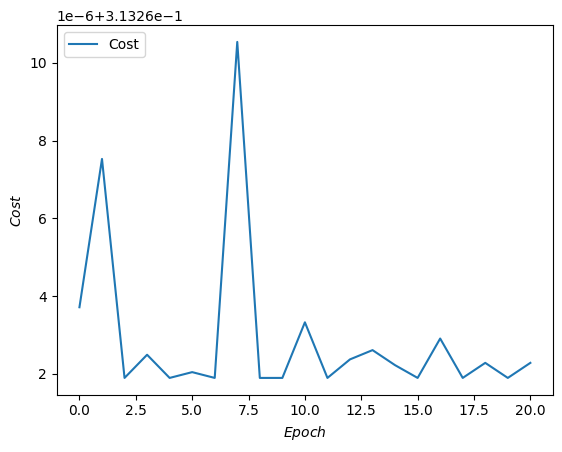

In [ ]:
model.train()

x_axis = []
y_axis = []

for epoch in range(21):
  for x_train, y_train in train_loader:
    x_train = x_train.to(device)
    y_train = y_train.to(device)

    pred = model(x_train).to(device)
    cost = loss(pred, y_train).to(device)
    correct_pred = torch.argmax(pred, 1) == y_train
    accuracy = correct_pred.float().mean()

    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

  x_axis.append(epoch)
  y_axis.append(cost.item())

  print("Epoch {:2d} / {} Cost: {:.5f} Training ACC: {:.2f}%".\
          format(epoch+1, 20, cost.item(), accuracy*100))

fig, x1 = plt.subplots()
x1.set_xlabel('$Epoch$')
x1.set_ylabel('$Cost$')
x1.plot(x_axis, y_axis, label="Cost")
x1.legend(loc='upper left')
plt.show()

In [ ]:
#Validation Accuracy
model.eval()

with torch.no_grad():
  for x_val, y_val in val_loader:
    x_val = x_val.to(device)
    y_val = y_val.to(device)

    pred = model(x_val).to(device)
    correct_pred = torch.argmax(pred, 1) == y_val
    accuracy = correct_pred.float().mean()
  print("Validation Accuracy: {:.2f}".format(accuracy.item()*100))

Validation Accuracy: 99.90


In [ ]:
#Testing Accuracy

model.eval()

with torch.no_grad():
  for x_test, y_test in test_loader:
    x_test = x_test.to(device)
    y_test = y_test.to(device)

    pred = model(x_test).to(device)
    correct_pred = torch.argmax(pred, 1) == y_test
    accuracy = correct_pred.float().mean()
  print("Final Testing Accuracy: {:.2f}".format(accuracy.item()*100))

Final Testing Accuracy: 99.87


In [ ]:
#Build confusion matrix using the f1 score
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model(x_val).to(device)
y_pred = torch.argmax(y_pred, 1).to(device)

target_names = ['is_Normal', 'is_Attack']
print(classification_report(y_val.cpu(), y_pred.cpu(), target_names=target_names, digits=4))
print(confusion_matrix(y_val.cpu(), y_pred.cpu()))

              precision    recall  f1-score   support

   is_Normal     0.9972    1.0000    0.9986      4992
   is_Attack     1.0000    0.9985    0.9993      9456

    accuracy                         0.9990     14448
   macro avg     0.9986    0.9993    0.9989     14448
weighted avg     0.9990    0.9990    0.9990     14448

[[4992    0]
 [  14 9442]]


In [ ]:
#Build confusion matrix using the f1 score
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model(x_test).to(device)
y_pred = torch.argmax(y_pred, 1).to(device)

target_names = ['is_Normal', 'is_Attack']
print(classification_report(y_test.cpu(), y_pred.cpu(), target_names=target_names, digits=4))
print(confusion_matrix(y_test.cpu(), y_pred.cpu()))

#look at macro avg f1 score

#top right = False Neg
#top left = True Neg
#bottom right = True Pos
#bottom left = False Pos

              precision    recall  f1-score   support

   is_Normal     0.9964    0.9999    0.9982     12786
   is_Attack     1.0000    0.9980    0.9990     23333

    accuracy                         0.9987     36119
   macro avg     0.9982    0.9990    0.9986     36119
weighted avg     0.9987    0.9987    0.9987     36119

[[12785     1]
 [   46 23287]]


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
